In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias
from src.ForecastModel.utils.postprocessing import ModelHandler, find_best_models

import numpy as np
import pandas as pd

import json

# plot styling
plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 6,
})

In [2]:
PLOT_PATH = r"plots"
DATA_PATH = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [3]:
models = {
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "#ff7f00",
                ls = "--",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
               r"rst\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
               ls = "-",
              )
     }

dictonary loaded
dictonary loaded


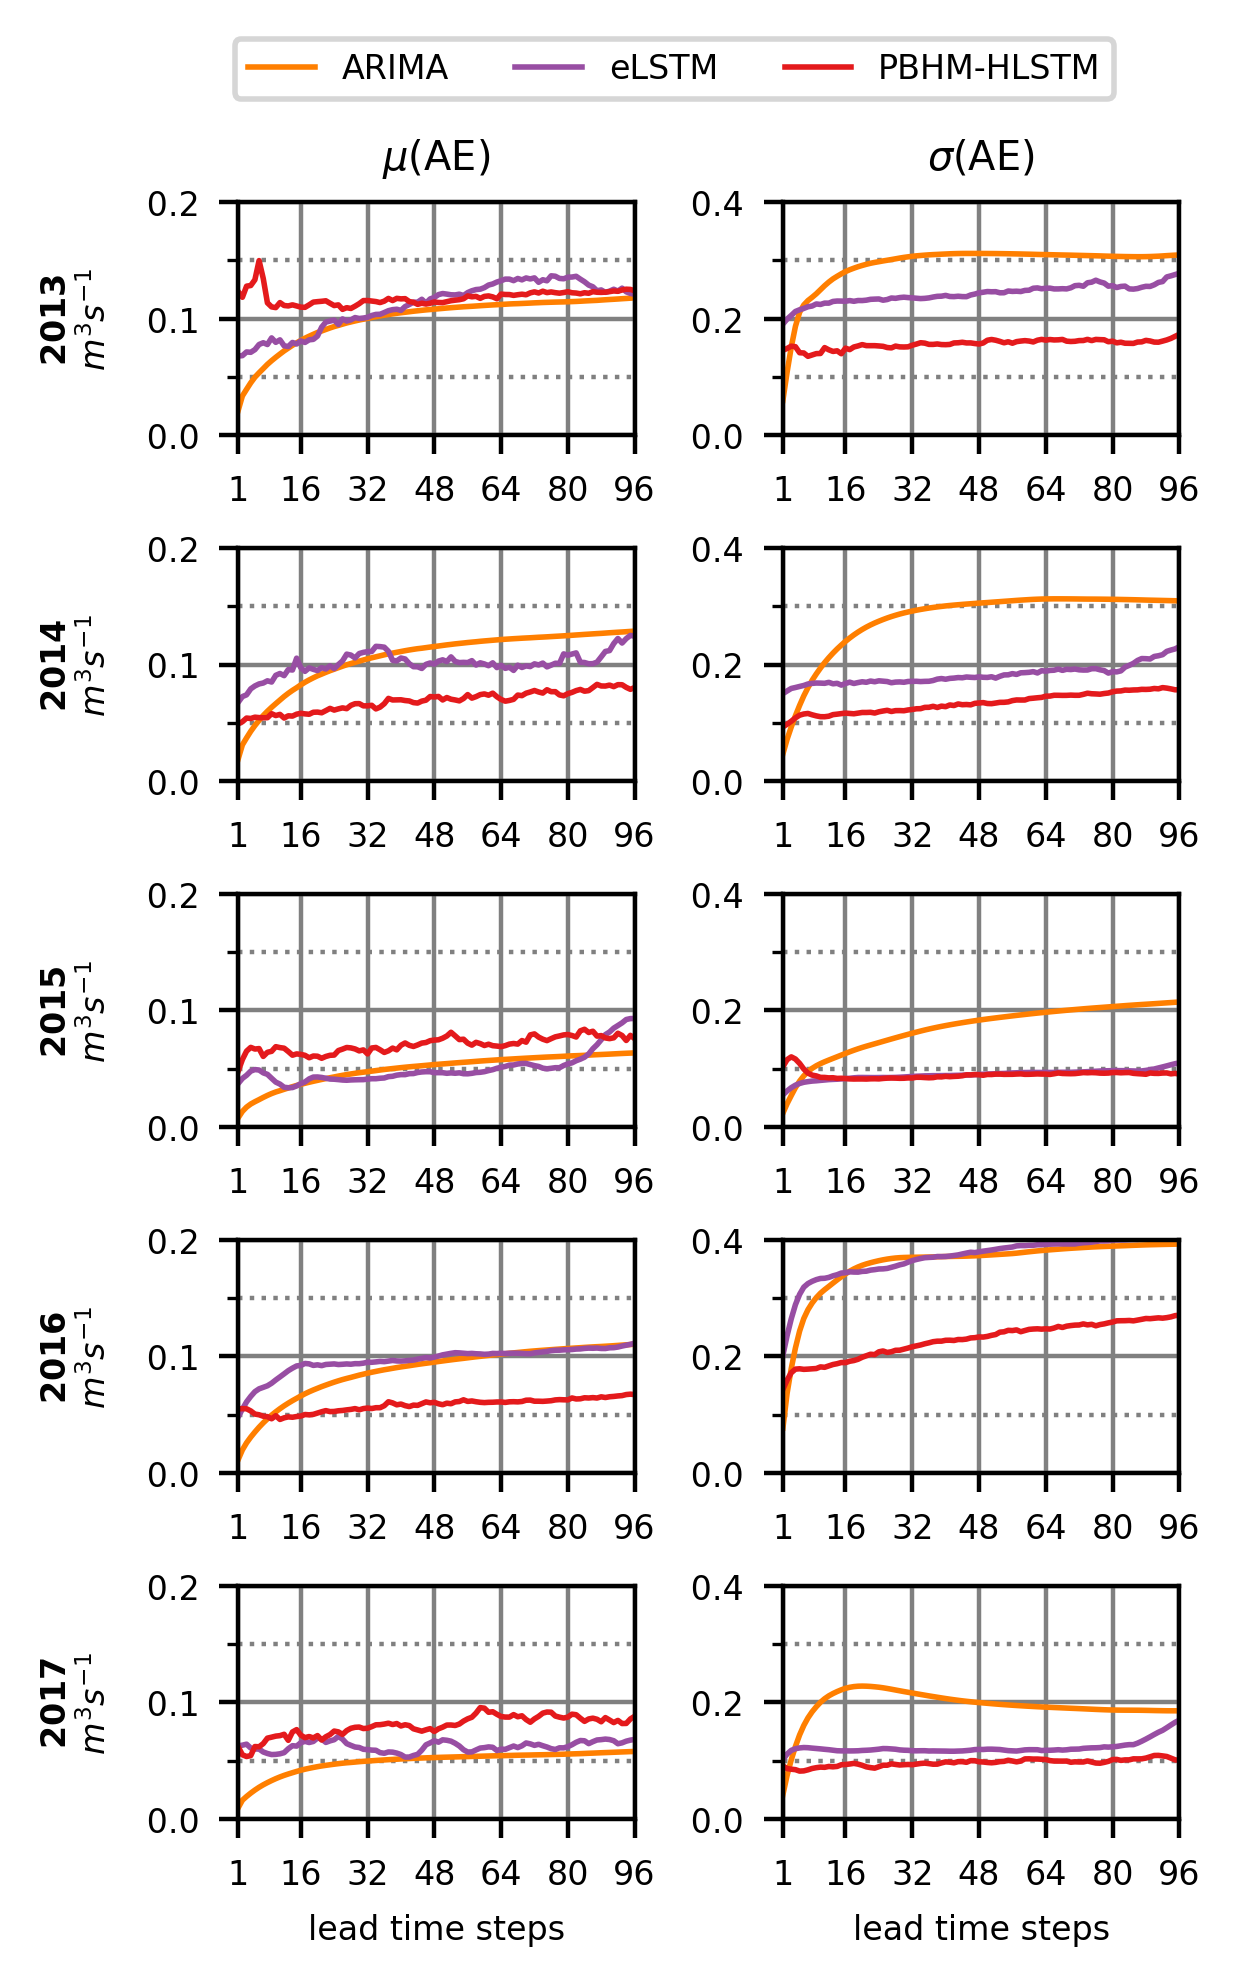

In [10]:
# initalize data frames for all flows and for >98% flows
df = pd.DataFrame(index=np.arange(2013,2018,dtype=int))
dfs = [df.copy(), df.copy()]

# process all folds


date_ranges = [['2013-01-06 00:00:00','2013-12-27 00:00:00'],
               ['2014-01-06 00:00:00','2014-12-27 00:00:00'],
               ['2015-01-06 00:00:00','2015-12-27 00:00:00'],
               ['2016-01-06 00:00:00','2016-12-27 00:00:00'],
               ['2017-01-06 00:00:00','2017-12-27 00:00:00']]

fig, axes = plt.subplots(5,2,figsize=(4.72*8.3/12,5), dpi=400)

for j, key in enumerate(models.keys()):   
    if models[key].is_external_model:
        overlap_length = 0
        hindcast_length = 96
    else:
        # load datamodel
        dm = DataModelCV(DATA_PATH,
           target_name       = models[key].target_name,
           hincast_features  = models[key].feat_hindcast,
           forecast_features = models[key].feat_forecast,
         )
        
        # load trial data
        with open(os.path.join(models[key].hp_path, "trial.json")) as f:
            trial = json.load(f)

        hindcast_length = trial['hyperparameters']['values']['hindcast_length']
        try:
            overlap_length = trial['hyperparameters']['values']['osc_length']
        except:
            overlap_length = 0 
        
        dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))
    
    for n_fold in range(5):
        year = 2013 + n_fold
        if models[key].is_external_model:
            # load external which come already with observations
            ext_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))

            # get external model observations
            y = np.expand_dims(ext_df.filter(like="obs").values, axis=2) # fix 

            # get external model predictions
            yp = ext_df.filter(like="fc").values
                        
        else:
            # load dataset
            X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 
            
            if os.path.exists(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")):
                yp = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")).values
            else:
                # load model and predict
                tf.keras.backend.clear_session()
                model  = tf.keras.models.load_model(os.path.join(models[key].hp_path, f"model_fold_{n_fold:d}.keras"))                          

                # model prediction
                yp = model.predict(X, batch_size=1000)

        y = y[:,:,0]
        ae = np.abs(y-yp)
        ae_mean = np.mean(ae, axis=0)
        ae_std  = np.std(ae, axis=0)
        
        fhv_mask = y > np.quantile(y.flatten(), 0.98) # high volume flows
        fhv_ae = np.zeros_like(ae) * np.nan
        fhv_ae[fhv_mask] = ae[fhv_mask]
        fhv_ae_mean = np.nanmean(fhv_ae, axis=0)
        fhv_ae_std  = np.nanstd(fhv_ae, axis=0)
        
        
        x = np.arange(1,len(ae_mean)+1)
       # axes[n_fold, j].fill_between(x,ae_std, color=models[key].color, alpha=0.25, label="MAE - "+"$\sigma$")
        axes[n_fold, 0].plot(x,ae_mean, color=models[key].color, lw=1, label=models[key].name)
        axes[n_fold, 1].plot(x,ae_std, color=models[key].color, lw=1)

        #axes[n_fold, 1].fill_between(x,fhv_ae_mean+fhv_ae_std, fhv_ae_mean-fhv_ae_std, color=models[key].color, alpha=0.25)
        #axes[n_fold, 1].plot(x,fhv_ae_mean, color=models[key].color)

        for j in range(2):
            axes[n_fold,j].set_xticks(np.array([1,16,32,48,64,80,96]))
            #axes[n_fold,j].set_yticks([0,0.1,0.2,0.3,0.4])
    
            
            axes[n_fold,j].set_xlim(1, 96)
                
            axes[n_fold,j].yaxis.set_major_formatter('{x: 4.1f}')
            
            axes[n_fold,j].grid(which='major', color='grey', linestyle='-')
            axes[n_fold,j].grid(which='minor', color='grey', linestyle=':')
            
            if j == 0:
                #secax = axes[n_fold,j].twinx()
                #axes[n_fold,j].set_ylabel("all flows\n"+f"{2013 + n_fold}", fontweight="bold")
    
                axes[n_fold,j].set_ylabel(r"$\bf{"+f"{2013 + n_fold}"+r"}$" +"\n$m^3s^{-1}$")
                axes[n_fold,j].set_ylim([0,0.2])
                axes[n_fold,j].yaxis.set_major_locator(MultipleLocator(0.1))
                axes[n_fold,j].yaxis.set_minor_locator(MultipleLocator(0.05))
            elif j == 1:
                axes[n_fold,j].set_ylim([0,0.4])
                axes[n_fold,j].yaxis.set_major_locator(MultipleLocator(0.2))
                axes[n_fold,j].yaxis.set_minor_locator(MultipleLocator(0.1))
                

               # secax.set_yticks([0,0.1,0.2,0.3,0.4])
                #secax.set_ylim([0,0.4])
                #axes[n_fold,j].set_yticks([])
                #secax.grid()
            #else:
                #axes[n_fold,j].yaxis.set_label_position("right")
               # axes[n_fold,j].yaxis.set_ticks_position("right")
                
           # if j == 2: 
            #    axes[n_fold,j].set_ylabel("$m^3s^{-1}$")
                
            if n_fold == 0:
                axes[n_fold,0].set_title("$\mu$(AE)")
                axes[n_fold,1].set_title("$\sigma$(AE)")
            elif n_fold == 4:
                axes[n_fold,j].set_xlabel('lead time steps')

    

#fig.suptitle("all flows", fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.89, right=0.9)
axes[0,0].legend(bbox_to_anchor=(1.1, 1.3),
                  loc='lower center', ncol=3, 
                  borderaxespad=1)

In [12]:
fig.savefig(os.path.join(PLOT_PATH, 'fig7_MAE_all_flows.png'), bbox_inches="tight", dpi=300)

In [6]:
dfs[0]

""
2013
2014
2015
2016
2017


In [7]:
dfs[1]

""
2013
2014
2015
2016
2017
